## Все инпуты оставим сверху.

In [ ]:
import numpy as np
import pandas as pd 
import os
from tqdm import tqdm
from shapely.geometry import box
import time
from haversine import haversine
from matplotlib import pyplot as plt 
import seaborn as sns

In [ ]:
!pip install geopandas

In [ ]:
import geopandas as gp

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
train = pd.read_csv('/kaggle/input/cft-shift2022/train.csv')
test = pd.read_csv('/kaggle/input/cft-shift2022/test.csv')

## Сходим на https://download.geofabrik.de/osm-data-in-gis-formats-free.pdf и поищем там описание объектов, которые могут быть нам интересны.

### Также нам понадобятся радиусы, в которых мы будем искать объекты. Понятно, что для объектов различного типа эти расстояния могут заметно отличаться.

In [ ]:
shift_1k = 0.01 #на сколько нужно отодвинуть углы от центра, чтобы получить квадрат со стороной 2 километра
shift_2k = 0.02
shift_05k = 0.005

In [ ]:
interesting_places = list()

In [ ]:
transport = '/kaggle/input/osm-central-region-of-russia/central-fed-district-latest-free.shp/gis_osm_transport_free_1.shp'

In [ ]:
#транспорт.
interesting_places.append({'layer' : transport, 'code' : 5601, 'range': shift_2k}) #вокзал (?), большая ж/д станция.
interesting_places.append({'layer' : transport, 'code' : 5602, 'range': shift_2k}) #ж/д станция поменьше. 
interesting_places.append({'layer' : transport, 'code' : 5621, 'range': shift_05k}) #автобусная остановка.

In [ ]:
points_of_interest = '/kaggle/input/osm-central-region-of-russia/central-fed-district-latest-free.shp/gis_osm_pois_a_free_1.shp'

In [ ]:
#здоровье.
interesting_places.append({'layer' : points_of_interest, 'code' : 2110, 'range': shift_2k}) #больница.
interesting_places.append({'layer' : points_of_interest, 'code' : 2101, 'range': shift_05k}) #аптека.

In [ ]:
#разного рода досуг.
interesting_places.append({'layer' : points_of_interest, 'code' : 2201, 'range': shift_2k}) #театр.
interesting_places.append({'layer' : points_of_interest, 'code' : 2203, 'range': shift_1k}) #кинотеатр.
interesting_places.append({'layer' : points_of_interest, 'code' : 2204, 'range': shift_05k}) #парк.
interesting_places.append({'layer' : points_of_interest, 'code' : 2251, 'range': shift_1k}) #спортивный центр 
                                                                 #(видимо, что-то типа зала свозможностью аренды помещения).
interesting_places.append({'layer' : points_of_interest, 'code' : 2253, 'range': shift_1k}) #бассейн.

In [ ]:
#предприятия общественного питания (?).
interesting_places.append({'layer' : points_of_interest, 'code' : 2301, 'range': shift_1k}) #ресторан.
interesting_places.append({'layer' : points_of_interest, 'code' : 2303, 'range': shift_1k}) #кафе.
interesting_places.append({'layer' : points_of_interest, 'code' : 2304, 'range': shift_1k}) #бар/паб.

In [ ]:
#бакалея.
interesting_places.append({'layer' : points_of_interest, 'code' : 2501, 'range': shift_05k}) #супермаркет.

In [ ]:
#офисы банков и банкоматы.
interesting_places.append({'layer' : points_of_interest, 'code' : 2601, 'range': shift_2k}) #банк.
interesting_places.append({'layer' : points_of_interest, 'code' : 2602, 'range': shift_05k}) #банкомат.

In [ ]:
points_of_worship = '/kaggle/input/osm-central-region-of-russia/central-fed-district-latest-free.shp/gis_osm_landuse_a_free_1.shp'

In [ ]:
#религиозные сооружения.
interesting_places.append({'layer' : points_of_worship, 'code' : 3100, 'range': shift_1k}) #христиане.
interesting_places.append({'layer' : points_of_worship, 'code' : 3300, 'range': shift_1k}) #мусульмане.

In [ ]:
#различные общественные службы.
interesting_places.append({'layer' : points_of_interest, 'code' : 2001, 'range': shift_2k}) #отдел полиции.
interesting_places.append({'layer' : points_of_interest, 'code' : 2002, 'range': shift_2k}) #пожарная часть.
interesting_places.append({'layer' : points_of_interest, 'code' : 2082, 'range': shift_05k}) #школа.
interesting_places.append({'layer' : points_of_interest, 'code' : 2083, 'range': shift_05k}) #детский сад.

In [ ]:
#возвращает кол-во объектов заданного типа в заранее определённом для него радиусе.
def get_number_of_object(long, lat, obj):
    distance = obj['range']
    temp_box = box(long - distance, lat - distance, long + distance, lat + distance);
    objects = gp.read_file(
        obj['layer'],
        bbox = temp_box
    )
    correct_objects = objects[objects.code == obj['code']]
    return correct_objects.shape[0]

In [ ]:
#пробегаем по всем интересным нам объектам и смотрим их кол-во.
def get_number_of_all_objects(long, lat):
    return [get_number_of_object(long, lat, obj) for obj in interesting_places] 

In [ ]:
new_columns = [
    'big station',
    'small station',
    'bus stop',
    
    'hospital',
    'pharmacy',
    
    'theatre',
    'cinema',
    'park',
    'sport centre',
    'swimming pool',
    
    'restaurant',
    'cafe',
    'bar',
    
    'store',
    
    'bank',
    'atm',
    
    'chrisians',
    'muslims',
    
    'police',
    'fire station',
    'school',
    'kindergarten'
]

In [ ]:
def add_new_features_train(df):
    new_dataframe = np.zeros((train.shape[0], 24))
    
    for ind, elem in tqdm(df.iterrows()):
        new_dataframe[ind, :] = ([elem['ID'], elem['target']] + get_number_of_all_objects(elem['longitude'], elem['latitude']))
    return pd.DataFrame(new_dataframe, columns = ['id', 'target'] + new_columns)

In [ ]:
def add_new_features_test(df):
    new_dataframe = np.zeros((test.shape[0], 23))
    
    for ind, elem in tqdm(df.iterrows()):
        new_dataframe[ind, :] = ([elem['ID']] + get_number_of_all_objects(elem['longitude'], elem['latitude']))
    return pd.DataFrame(new_dataframe, columns = ['id'] + new_columns)

### Сейчас новые трейн и тест собирать не будем - это займёт часов 16. Но я сделала это заранее, поэтому просто подгрузим их.  

In [ ]:
#new_train = add_new_features_train(train)
#new_train.to_csv('new_train.csv',index=False)

In [ ]:
#new_test = add_new_features_test(test)
#new_test.to_csv('new_test.csv',index=False)

In [ ]:
new_train = pd.read_csv('../input/shift-cft-new-train-dataset/new_train.csv', index_col=0)
new_train.head()

,target,big station,small station,bus stop,hospital,pharmacy,theatre,cinema,park,sport centre,...,bar,store,bank,atm,chrisians,muslims,police,fire station,school,kindergarten
id,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,3.0,0.0,20.0,6.0,0.0,2.0,0.0,2.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,3.0
1.0,1.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
2.0,1.0,4.0,2.0,10.0,1.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,4.0
3.0,1.0,2.0,1.0,2.0,5.0,0.0,0.0,0.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0
4.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0


In [ ]:
new_test = pd.read_csv('../input/shift-cft-new-test-dataset/shift-cft-new-test-dataset.csv', index_col=0)
new_test.head()

,id,big station,small station,bus stop,hospital,pharmacy,theatre,cinema,park,sport centre,...,bar,store,bank,atm,chrisians,muslims,police,fire station,school,kindergarten
0,8000.0,11.0,0.0,17.0,7.0,0.0,1.0,0.0,4.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,3.0,1.0
1,8001.0,7.0,3.0,20.0,4.0,0.0,2.0,0.0,2.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2,8002.0,2.0,1.0,14.0,2.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,5.0,5.0
3,8003.0,14.0,2.0,6.0,10.0,0.0,13.0,0.0,3.0,2.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,4.0,3.0
4,8004.0,5.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0


## Теперь проведём некий анализ, посмотрим, как целевая переменная связана с различными признаками.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


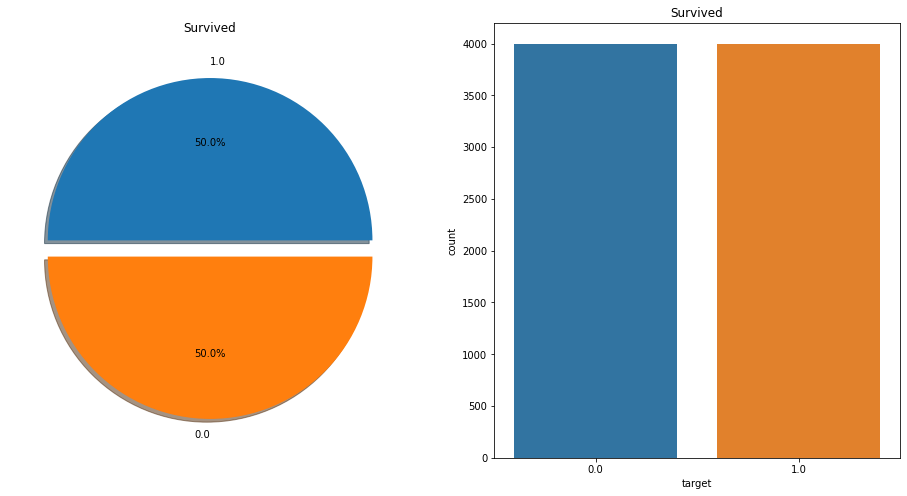

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(16,8))
train['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axes[0],shadow=True)
axes[0].set_title('Survived')
axes[0].set_ylabel('')
sns.countplot('target',data=train,ax=axes[1])
axes[1].set_title('Survived')
plt.show()

#### Как видно, у нас ровно половина значений из одного класса, и половина же - из второго, это хорошо, ведь нам не придётся учитывать баланс классов.

#### Среди тех признаков, что я выбрала, важными вполне могут оказаться не все, посмотрим, как таргет связан с некторыми из них.

#### Посмотрим, как кол-во школ может влиять на надёжность заёмщика.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


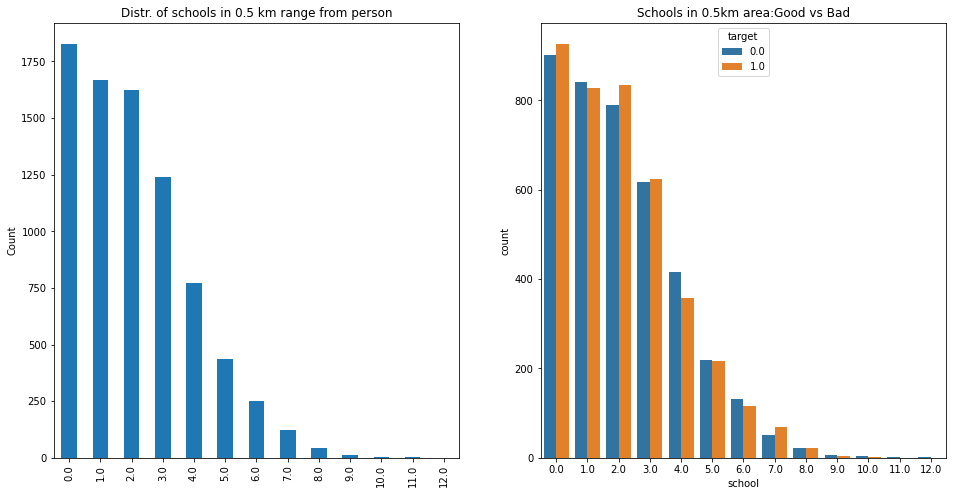

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(16,8))
new_train['school'].value_counts().plot.bar(ax=axes[0])
axes[0].set_title('Distr. of schools in 0.5 km range from person')
axes[0].set_ylabel('Count')

sns.countplot('school',hue='target',data=new_train,ax=axes[1])
axes[1].set_title('Schools in 0.5km area:Good vs Bad')
plt.show()

#### Как мы видим, от кол-ва школ рядом с местом обитания заёмщика практически ничего не зависит.

#### Теперь выясним, как кол-во различного рода досуговых центров влияет на таргет.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


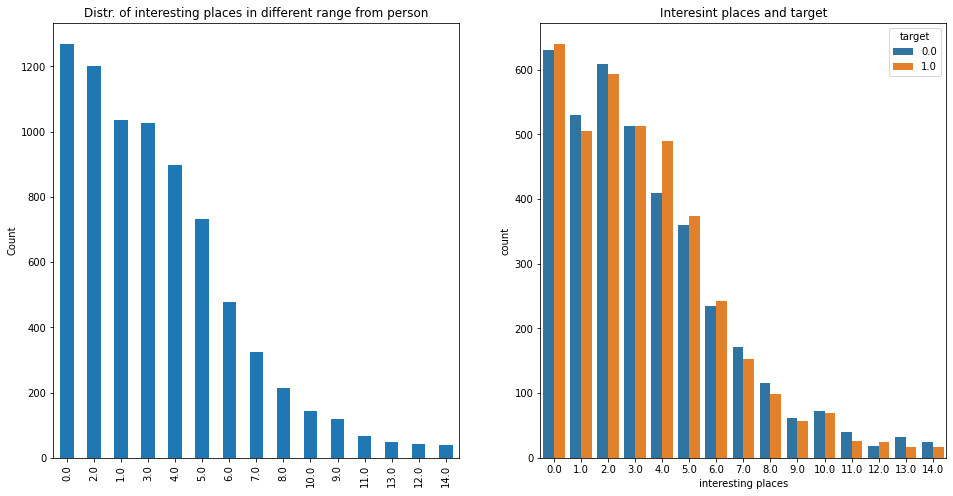

In [ ]:
temp = pd.DataFrame(new_train['target'], columns=['target'])
temp['interesting places'] = new_train['park'] + new_train['theatre'] + new_train['cinema'] + new_train['sport centre'] + new_train['swimming pool'] 
temp = temp[temp['interesting places'] < 15]
#чуть обрежем фрейм - дальше данные немногочисленны, но они портят внешний вид графиков.

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
temp['interesting places'].value_counts().plot.bar(ax=axes[0])
axes[0].set_title('Distr. of interesting places in different range from person')
axes[0].set_ylabel('Count')
sns.countplot('interesting places',hue='target',data=temp,ax=axes[1])
axes[1].set_title('Interesint places and target')
plt.show()

#### К сожалению, и здесь никаких явных, хотя есть слабая тенденция - чем больше подобного рода заведений, тем хуже, если смотреть на значения 0-6 

####  Быть может, ж/д траспорт как-то прояснит картину.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


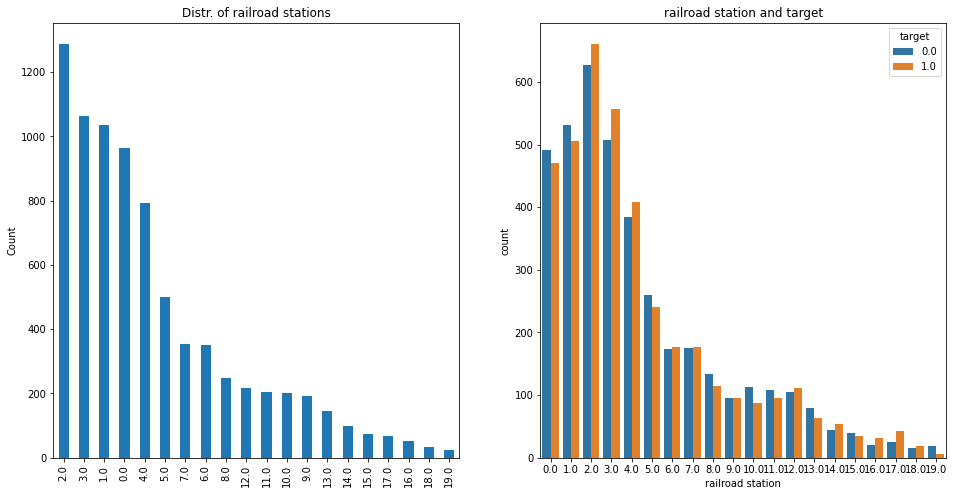

In [ ]:
temp = pd.DataFrame(new_train['target'], columns=['target'])
temp['railroad station'] = new_train['big station'] + new_train['small station']
temp = temp[temp['railroad station'] < 20]
#чуть обрежем фрейм - дальше данные немногочисленны, но они портят внешний вид графиков.

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
temp['railroad station'].value_counts().plot.bar(ax=axes[0])
axes[0].set_title("Distr. of railroad stations")
axes[0].set_ylabel('Count')
sns.countplot('railroad station',hue='target',data=temp,ax=axes[1])
axes[1].set_title('railroad station and target')
plt.show()

#### В очередной раз, провал, но всё же: если станция одна или их нет вообще, для нас это лучше, чем если станций 2,3 или 4.

In [ ]:
new_train.columns

Index(['target', 'big station', 'small station', 'bus stop', 'hospital',
       'pharmacy', 'theatre', 'cinema', 'park', 'sport centre',
       'swimming pool', 'restaurant', 'cafe', 'bar', 'store', 'bank', 'atm',
       'chrisians', 'muslims', 'police', 'fire station', 'school',
       'kindergarten'],
      dtype='object')

#### Последняя группа объектов - рестораны, кафе и бары, обычно, их располагают в более богатых и благополучных районах.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


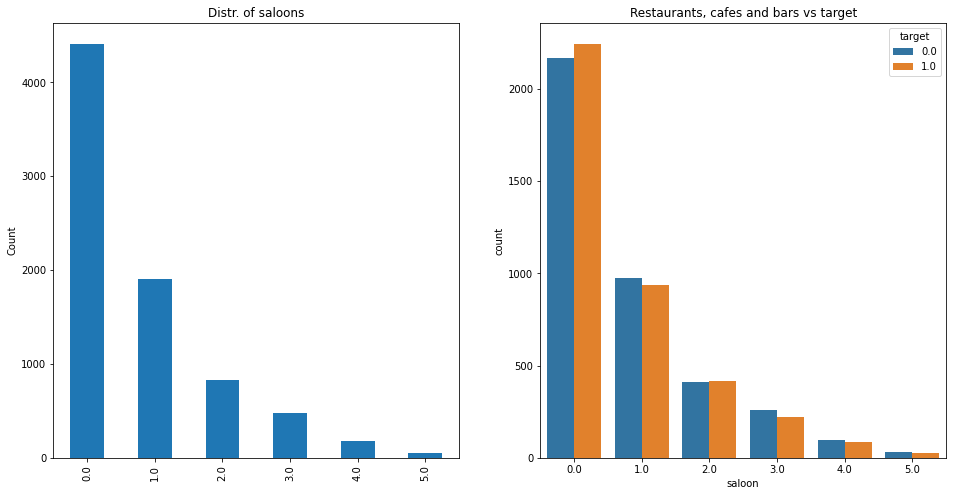

In [ ]:
temp = pd.DataFrame(new_train['target'], columns=['target'])
temp['saloon'] = new_train['restaurant'] + new_train['cafe'] + new_train['bar'] 
temp = temp[temp['saloon'] < 6]
#чуть обрежем фрейм - дальше данные немногочисленны, но они портят внешний вид графиков.

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
temp['saloon'].value_counts().plot.bar(ax=axes[0])
axes[0].set_title("Distr. of saloons")
axes[0].set_ylabel('Count')
sns.countplot('saloon',hue='target',data=temp,ax=axes[1])
axes[1].set_title('Restaurants, cafes and bars vs target')
plt.show()

#### Снова мимо.

#### Посмотрим, как скоррелированы наши признаки.

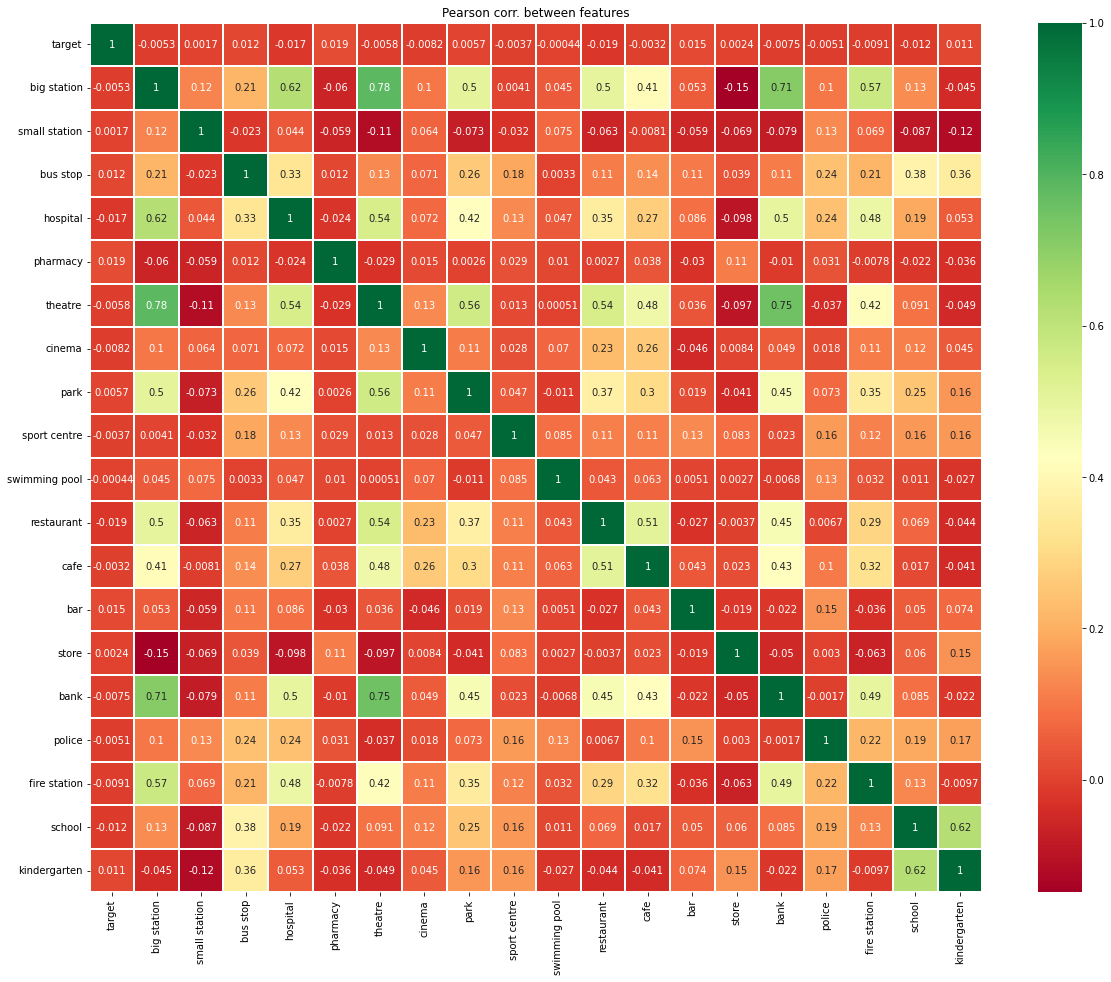

In [ ]:
sns.heatmap(new_train.drop(['atm','chrisians', 'muslims'], axis=1).corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.title('Pearson corr. between features')
plt.show()

#### Большинство данных скоррелированы слабо, но вот кол-во банков и больших ж/д станций, а такде кол-во больших станций и театров неплохо скоррелированы - возможно, будет лучше избавиться от двух из этих троих в будущем.